# 1 Introducción

El siguiente ejemplo modifica el color de una imagen parametrizada y detecta sus bordes mediante el filtro de Sobel, utilizando la técnica de clamp para limitar los valores de los píxeles dentro de un rango válido.

Para aplicar este filtro se deben realizar los siguientes pasos, en el orden indicado:

1.  Aplicar un filtro de escala de grises.
2.  Aplicar el algoritmo de convolución con las máscaras de Sobel (horizontal y vertical) para obtener el gradiente.
3.  Calcular el valor máximo de los píxeles de la imagen resultante.
4.  Normalizar la imagen a una escala de 0 a 255.




#Enunciado del Ejercicio
Teniendo en cuenta el código secuencial del programa que detecta los bordes de una imagen y que se ejecuta en la CPU, que es mostrado a continuación, genere un kernel para ejecutar el mismo algoritmo de forma paralela en la GPU.

Para ello, realice las siguientes tareas en este orden:

1.  Convierta el programa secuencial, que maneja la imagen mediante un arreglo bidimensional, a una versión que utilice acceso mediante un arreglo unidimensional.

2.  Complete el fragmento de código del kernel de la GPU que se encuentra incompleto, basándose en el código secuencial.




# 2 Armado del ambiente


#Carga de un arhivo imagen
Utilice el siguien script para subir archivo jpg de su PC a la nube, para poder este usarlo en los filtros de imagenes

In [10]:
from google.colab import files

# Muestra el botón para seleccionar un archivo
uploaded = files.upload()

# Renombra automáticamente el archivo cargado a 'imagen.jpg'
import os

for filename in uploaded.keys():
    os.rename(filename, "imagen.jpg")
    print(f"Archivo '{filename}' cargado y renombrado a 'imagen.jpg'")


Saving imagen.jpeg to imagen.jpeg
Archivo 'imagen.jpeg' cargado y renombrado a 'imagen.jpg'


---
## 2.2 Instala en el cuaderno el módulo CUDA de Python.

In [3]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 12.0 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=bfcf8e2ec8743e2de2ab6be127b603469730fd60e728645a713caead0e57bc05
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda


---
# 3 Desarrollo
# Ejecución en CPU
Ejecución del algoritmo del filtro de brllo ejecutandose en form secuencial en  la CPU

## **a) Sobel Secuencial (Usando Array bidimensional)**




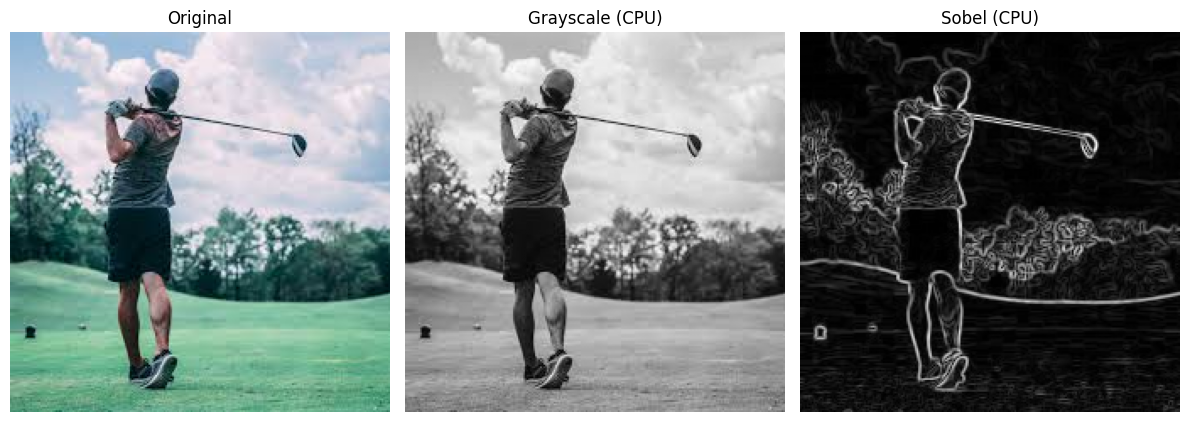

Guardado: sobel_output.jpg


In [11]:
from PIL import Image
import math
import matplotlib.pyplot as plt
import numpy as np

# -------- Máscaras de Sobel (3x3) --------
SOBEL_X = [[-1, 0, 1],
           [-2, 0, 2],
           [-1, 0, 1]]

SOBEL_Y = [[-1, -2, -1],
           [ 0,  0,  0],
           [ 1,  2,  1]]

# ----------- Función auxiliar -------------
def clamp(v, lo, hi):
    """Limita v para que quede dentro del rango [lo, hi]."""
    if v < lo:
        return lo
    if v > hi:
        return hi
    return v


# ----------- RGB -> Gris (arr[x][y]) -------------
def apply_grayscale_image(img_rgb, w, h):
    """Convierte imagen RGB a array 2D (float) de grises como gray[x][y]."""
    px = img_rgb.load()
    gray = [[0.0 for _ in range(h)] for _ in range(w)]

    for x in range(w):
        for y in range(h):
            r, g, b = px[x, y]
            gray[x][y] = 0.299 * r + 0.587 * g + 0.114 * b

    return gray

# ----------- Filtro Sobel 2D (arr[x][y]) --------------
def sobel_magnitude_array(gray_array, w, h):
    """
    Calcula magnitud Sobel leyendo de un array 2D gray[x][y].
    Devuelve lista 2D mag[x][y] (floats).
    """
    mag = [[0.0 for _ in range(h)] for _ in range(w)]

    for x in range(w):
        for y in range(h):
            gx = 0.0
            gy = 0.0
            for kx in range(-1, 2):
                for ky in range(-1, 2):
                    xx = clamp(x + kx, 0, w - 1)
                    yy = clamp(y + ky, 0, h - 1)
                    pixel = float(gray_array[xx][yy])  # ahora [x][y]
                    gx += SOBEL_X[ky + 1][kx + 1] * pixel
                    gy += SOBEL_Y[ky + 1][kx + 1] * pixel
            mag[x][y] = math.sqrt(gx * gx + gy * gy)
    return mag

# ----------- Normalización 0..255 (solo matriz [x][y]) -----------
def normalize_to_0_255_matrix(mag_xy, w, h):
    """
    Normaliza mag[x][y] a 0..255.
    Devuelve nueva matriz out[x][y] de enteros.
    No genera imagen PIL.
    """
    max_val = 0.0
    for x in range(w):
        for y in range(h):
            v = float(mag_xy[x][y])
            if v > max_val:
                max_val = v

    out = [[0 for _ in range(h)] for _ in range(w)]

    if max_val <= 1e-8:
        return out

    scale = 255.0 / max_val
    for x in range(w):
        for y in range(h):
            val = mag_xy[x][y] * scale
            if val < 0:
                val = 0
            elif val > 255:
                val = 255
            out[x][y] = int(val)
    return out

# ----------- Matriz -> Imagen PIL (arr[x][y]) -----------
def array_to_image_gray(arr_xy, w, h):
    """Convierte matriz arr[x][y] a imagen PIL 'L' con putpixel()."""
    img = Image.new("L", (w, h))
    px_img = img.load()
    for x in range(w):
        for y in range(h):
            px_img[x, y] = int(arr_xy[x][y])
    return img

# ----------- Mostrar imágenes --------------
def show_image(img_original, img_gray_L, img_sobel_L):
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    axs[0].imshow(img_original)
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(img_gray_L, cmap="gray")
    axs[1].set_title("Grayscale (CPU)")
    axs[1].axis("off")

    axs[2].imshow(img_sobel_L, cmap="gray")
    axs[2].set_title("Sobel (CPU)")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

# ----------- Pipeline completo ------------
def sobel_image_file(in_path, out_path):
    out_path_gray = "gray_scale_output.jpg"

    img_original = Image.open(in_path).convert("RGB")
    w, h = img_original.size

    array_gray_scale = apply_grayscale_image(img_original, w, h)
    array_sobel = sobel_magnitude_array(array_gray_scale, w, h)

    # Normalización (solo matriz)
    norm_xy = normalize_to_0_255_matrix(array_sobel, w, h)

    # Convertimos a imagen PIL fuera de la función
    img_gray_scale = array_to_image_gray(array_gray_scale, w, h)
    img_sobel = array_to_image_gray(norm_xy, w, h)

    img_gray_scale.save(out_path_gray)
    img_sobel.save(out_path)

    show_image(img_original, img_gray_scale, img_sobel)

    print(f"Guardado: {out_path}")

# ----------- Ejemplo de uso ---------------
if __name__ == "__main__":
    sobel_image_file("imagen.jpg", "sobel_output.jpg")


# Ejecución en GPU
Ejecución del algoritmo del filtro de brllo ejecutandose en forma paralaela en  la GPU

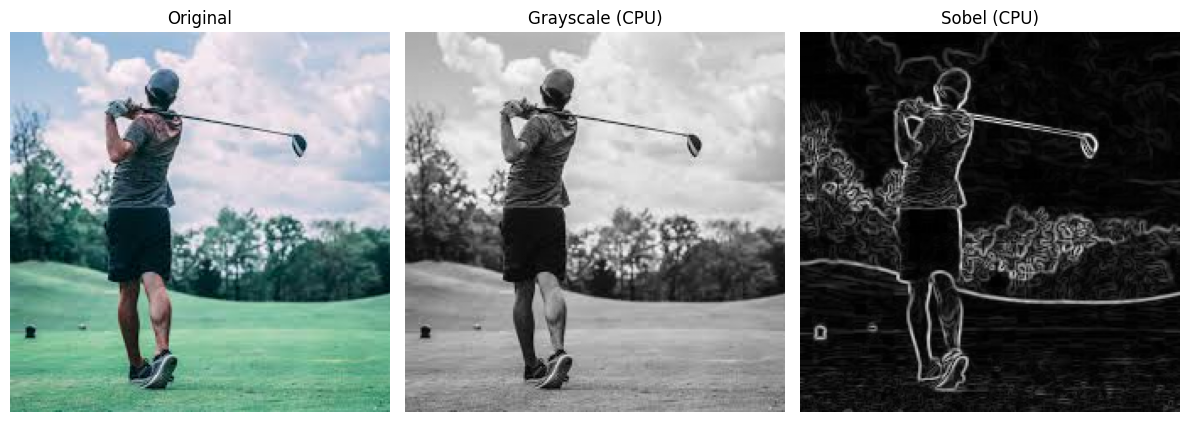

In [12]:
from pycuda.compiler import SourceModule
import pycuda.autoinit
import pycuda.driver as cuda
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

kernel_code = r"""
// -------- clamp entero --------
__device__ __forceinline__ int clampi(int v, int lo, int hi)
{
    if (v < lo) return lo;
    if (v > hi) return hi;
    return v;
}



extern "C" __global__
void apply_scale_gray_kernel(const unsigned char* __restrict__ rgb,
                        float* __restrict__ gray,
                        int w, int h)
{
    int x = blockIdx.x * blockDim.x + threadIdx.x; // 0..w-1
    int y = blockIdx.y * blockDim.y + threadIdx.y; // 0..h-1

     ************************************************************
     ***********COMPLETE AQUI EL CODIGO DEL KERNEL*****************
     ************** PARA ESCALA DE GRISES *************************
     **************************************************************
}

// ---- KERNEL: Sobel con tablas + clampi ----
extern "C" __global__
void apply_sobel_kernel(const float* __restrict__ gray,
                            float* __restrict__ mag,
                            int w, int h)
{
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= w || y >= h) return;

    // Tablas Sobel (3x3) aplanadas
    const float SOBEL_X[9] = {
        -1.f, 0.f, 1.f,
        -2.f, 0.f, 2.f,
        -1.f, 0.f, 1.f
    };
    const float SOBEL_Y[9] = {
        -1.f, -2.f, -1.f,
         0.f,  0.f,  0.f,
         1.f,  2.f,  1.f
    };

     ************************************************************
     ***********COMPLETE AQUI EL CODIGO DEL KERNEL*****************
     ************************* PARA SOBEL *************************
     **************************************************************
}

extern "C" __global__
void calculate_max_kernel(const float* __restrict__ mag,
                             unsigned int* __restrict__ d_max_bits,
                             int w, int h)
{
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if (x >= w || y >= h) return;

    int idx = y * w + x;
    float f = mag[idx];

    unsigned int bits = __float_as_uint(f);

    // d_max_bits apunta a memoria global inicializada en 0
    atomicMax(d_max_bits, bits);
}



// ===================================================================
extern "C" __global__
void normalize_to_0_255_kernel(const float* __restrict__ mag,
                               unsigned char* __restrict__ out_u8,
                               int w, int h,
                               float max_val)
{
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if (x >= w || y >= h) return;

    ************************************************************
    ***********COMPLETE AQUI EL CODIGO DEL KERNEL*****************
    ************** PARA NORMALIZAR SOBEL *************************
    **************************************************************
}
""";
# ==== Python host code ====
# ----------- Mostrar imágenes --------------
def show_image(img_original, img_gray_L, img_sobel_L):
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    axs[0].imshow(img_original)
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(img_gray_L, cmap="gray")
    axs[1].set_title("Grayscale (CPU)")
    axs[1].axis("off")

    axs[2].imshow(img_sobel_L, cmap="gray")
    axs[2].set_title("Sobel (CPU)")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

def main():
    mod = SourceModule(kernel_code)

    apply_scale_gray_kernel         = mod.get_function("apply_scale_gray_kernel")
    apply_sobel_kernel     = mod.get_function("apply_sobel_kernel")
    normalize_to_0_255_kernel  = mod.get_function("normalize_to_0_255_kernel")
    calculate_max_kernel = mod.get_function("calculate_max_kernel")

    # 1) Cargar imagen y preparar buffers
    img = Image.open("imagen.jpg").convert("RGB")
    w, h = img.size

    rgb_np   = np.asarray(img, dtype=np.uint8)
    rgb_flat = rgb_np.reshape(-1)

    gray_np = np.empty(w*h, dtype=np.float32)
    mag_np  = np.empty(w*h, dtype=np.float32)
    out_u8  = np.empty(w*h, dtype=np.uint8)

    # 2) Copia a device
    d_rgb       = cuda.mem_alloc(rgb_flat.nbytes)
    d_gray      = cuda.mem_alloc(gray_np.nbytes)
    d_mag       = cuda.mem_alloc(mag_np.nbytes)
    d_out       = cuda.mem_alloc(out_u8.nbytes)
    d_max_bits  = cuda.mem_alloc(np.uint32().nbytes)

    cuda.memcpy_htod(d_rgb, rgb_flat)
    cuda.memcpy_htod(d_max_bits, np.uint32(0))

    # 3) Config de grilla
    block = (16, 16, 1)
    grid  = ((w + block[0]-1)//block[0], (h + block[1]-1)//block[1], 1)

    # 4) RGB -> GRAY
    apply_scale_gray_kernel(d_rgb, d_gray, np.int32(w), np.int32(h), block=block, grid=grid)

    # 5) SOBEL magnitud
    apply_sobel_kernel(d_gray, d_mag, np.int32(w), np.int32(h), block=block, grid=grid)

    # 6) Traer gray y mag a CPU para visualizar
    cuda.memcpy_dtoh(gray_np, d_gray)
    cuda.memcpy_dtoh(mag_np,  d_mag)

    # 7) Calcular máximo en GPU (atomicMax sobre bits)
    calculate_max_kernel(d_mag, d_max_bits, np.int32(w), np.int32(h),block=block, grid=grid)

    # Leer máximo reinterpretando uint32 -> float32
    h_max_bits = np.empty(1, dtype=np.uint32)
    cuda.memcpy_dtoh(h_max_bits, d_max_bits)
    max_val = h_max_bits.view(np.float32)[0]

    # 8) Normalizar 0..255 en GPU
    normalize_to_0_255_kernel(d_mag, d_out, np.int32(w), np.int32(h), np.float32(max_val),block=block, grid=grid)

    # 9) Traer normalizado a CPU
    cuda.memcpy_dtoh(out_u8, d_out)

    # 10) Armar imágenes PIL para mostrar/guardar
    gray_u8  = np.clip(gray_np, 0, 255).astype(np.uint8).reshape(h, w)
    sobel_u8 = out_u8.reshape(h, w)

    img_gray  = Image.fromarray(gray_u8)
    img_sobel = Image.fromarray(sobel_u8)
    # 11) Mostrar en pantalla las 3 (original, grises, sobel normalizado
    show_image(img,img_gray,img_sobel)

    #guardo las imagenes en archivos
    img_gray.save("gray_output.jpg")
    img_sobel.save("sobel_output.jpg")

main()

---
# 4 Tabla de pasos


 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  wget url_imagen       | Lectura de la direcciòn URL de la imagen (jpg) a procesar.
CPU      | pip install pycuda    | Instala en el cuaderno los driver de CUDA para Python.
CPU      |  matplotlib inline    | Macro de Colab para mostrar imagenes.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  Image.open()          | Abre el archivo de la imagen.
CPU      |  numpy.asarray(imagen) | Convierte el formato comprimido JPG a RAW.
CPU      |  numpy.empty_like(()   | Genera el array destino, que tendrá a la imagen resultado.
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria para las imagenes en GPU.
**GPU**  |  cuda.memcpy_htod()    | Copio los valores en crudo de las imagenes al GPU.
CPU      |  SourceModule()        | Posee el còdigo del kernel.
CPU      |  module.get_function() | convierte el texto del kernel en funcion de Python.
CPU      |  dim_hilo_x, dim_hilo_y| Calcula las dimensiones para la ejecuciòn de 2D.
**GPU**  |  kernel()              | Ejecuta el kernel en GPU, enviando los parametros.
CPU      |  print()               | Informa los atributos de la imagen.
CPU      | cuda.memcpy_dtoh()     | Copia desde la memoria GPU al CPU.
CPU      |  plt.imshow            | Muestra la imagen original.
CPU      |  plt.imshow            | Muestra la imagen resultado.



---
# 5 Conclusiones

Las conclusiones son explicadas en clase...

---
# 6 Bibliografía

[1] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb)

[3] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[4] Algoritmo de filtro brillo en forma secuencial [PDF](https://hackernoon.com/es/algoritmos-de-procesamiento-de-imagen-ajuste-de-contraste-y-brillo-de-imagen-0y4y318a)
